In [ ]:
# @title Loading libraries

import glob
import os
import cv2
import sys

import random
from random import shuffle

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Neural Network

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.layers import BatchNormalization, Dropout

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import losses
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

# random seed

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# @title Mount google drive
# mount drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Data sets path

train_path = '/content/drive/MyDrive/Data Science Academy/Homeworks/Machine Learning/ML W8/train/'

test_path = '/content/drive/MyDrive/Data Science Academy/Homeworks/Machine Learning/ML W8/test/'

path = '/content/drive/MyDrive/Data Science Academy/Homeworks/Machine Learning/ML W8/'

train_data_path = path + 'train_data_100.npy' # 'train_data.npy' # 50x50
train_label_path = path + 'labels_100.txt'    # 'labels.txt' # 50x50

test_data_path = path + 'test_data_100.npy'
test_label_path = path + 'test_labels_100.txt'


In [ ]:
# @title Function for storing image files as list
# get image file list

def get_image_files(directory):
    image_files = []
    for root, dirs, files in tqdm(os.walk(directory)):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    shuffle(image_files) # shuffle the list
    return image_files


In [ ]:
# @title Get image file lists

train_files = get_image_files(train_path)
test_files = get_image_files(test_path)

1it [00:04,  4.81s/it]
1it [00:00,  1.85it/s]


In [ ]:
# @title Use this for geting a portion of the files

train_files = train_files[:]
test_files = test_files[:]

In [ ]:
# @title Check dimension of the lists

# type(train_files)
# print(f"Train files, Test files :")
len(train_files), len(test_files)

(25000, 12500)

In [ ]:
# @title Function for image files distribution within the list

def count_categories(file_paths):
    dog_count = 0
    cat_count = 0
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        if file_name.startswith('dog.'):
            dog_count += 1
        elif file_name.startswith('cat.'):
            cat_count += 1
    return dog_count, cat_count

# file_paths contains your list of file paths
dog_train, cat_train = count_categories(train_files)

print(f"Train data: \nNumber of dog files: {dog_train} \nNumber of cat files: {cat_train}")


Train data: 
Number of dog files: 12500 
Number of cat files: 12500


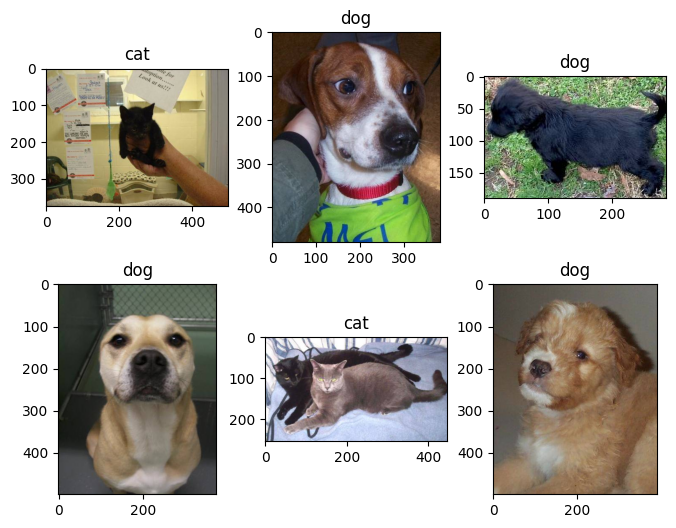

In [ ]:
# @title Images from train data set
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

for i in range(6):
    filename = train_files[i+20]
    title = filename.split('/')[-1].split('.')[0]
    image = imread(filename)
    axes[i // 3, i % 3].imshow(image)
    axes[i // 3, i % 3].set_title(title)

In [ ]:
# @title Image size and channels

# img_width  = 50
# img_height = 50

img_size = 100
img_channels   = 1

print("As we can see above, we have color images with different sizes,")
print("when read we will convert them into:\n")
print(f" grayscale image ->  (img_channels = {img_channels})")
print(f" size {img_size}x{img_size} -> (img_size = {img_size}) \n\nfor easier computation.")


As we can see above, we have color images with different sizes,
when read we will convert them into:

 grayscale image ->  (img_channels = 1)
 size 100x100 -> (img_size = 100) 

for easier computation.


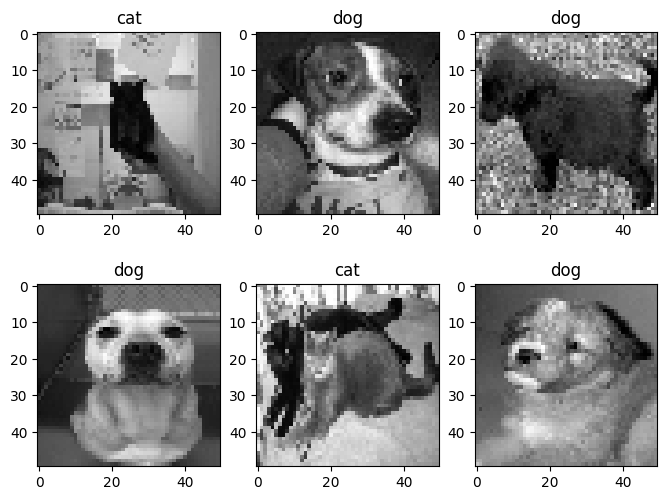

In [ ]:
# @title Grayscale images with size 50x50
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

for i in range(6):
    filename = train_files[i+20]
    title = filename.split('/')[-1].split('.')[0]
    image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (50, 50))
    axes[i // 3, i % 3].imshow(image,cmap='gray')
    axes[i // 3, i % 3].set_title(title)

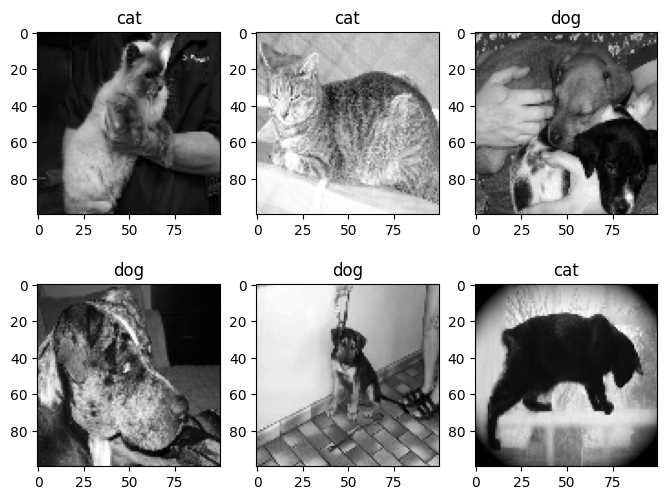

In [ ]:
# @title Grayscale images with size 100x100
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

for i in range(6):
    filename = train_files[i+20]
    title = filename.split('/')[-1].split('.')[0]
    image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (100, 100))
    axes[i // 3, i % 3].imshow(image,cmap='gray')
    axes[i // 3, i % 3].set_title(title)

### ***READING and STORING DATA***

In [ ]:
# @title Function for reading and storing train/test data into filles

def read_data(image_files, dataset_save_path, labels_save_path):
    dataset = np.zeros((len(image_files), img_size, img_size, img_channels))
    labels = []
    for i, image in tqdm(enumerate(image_files)):
        current_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        current_image = cv2.resize(current_image, (img_size, img_size))
        current_image = current_image.reshape((img_size, img_size, img_channels))
        current_image = current_image / 255
        dataset[i] = current_image

        # Extract label from file name
        file_name = os.path.basename(image)
        label = file_name.split('.')[0]  # Extract label from file name (e.g., 'dog' or 'cat')
        labels.append(label)

    # Save dataset
    np.save(dataset_save_path, dataset)

    # Save labels as a text file
    with open(labels_save_path, 'w') as f:
        for label in labels:
            f.write('%s\n' % label)

    return dataset, labels


In [ ]:
# @title Read TEST DATA into X_test, y_test

#y_test will not be used, test data files do not have labes -it is save just becuase of the stucture of the used function

X_test, y_test = read_data(test_files,test_data_path, test_label_path)

12500it [1:43:46,  2.01it/s]


In [ ]:
len(X_test), len(y_test)

(12500, 12500)

In [ ]:
# image 100x100x1
X_test[:1],y_test[:5]

(array([[[[0.44210786],
          [0.27252451],
          [0.27911767],
          ...,
          [0.8098039 ],
          [0.36573529],
          [0.33218139]],
 
         [[0.40784314],
          [0.36593136],
          [0.23588236],
          ...,
          [0.6036765 ],
          [0.55977941],
          [0.42078432]],
 
         [[0.22058824],
          [0.27683824],
          [0.41911766],
          ...,
          [0.4269608 ],
          [0.42671567],
          [0.47487745]],
 
         ...,
 
         [[0.1697304 ],
          [0.19080882],
          [0.15196079],
          ...,
          [0.40085784],
          [0.39742646],
          [0.50833333]],
 
         [[0.19914216],
          [0.21914215],
          [0.13446078],
          ...,
          [0.34558824],
          [0.41919118],
          [0.47789216]],
 
         [[0.20296568],
          [0.24549019],
          [0.12737745],
          ...,
          [0.38127449],
          [0.44019607],
          [0.44610295]]]]),
 ['1776', '

In [ ]:
# @title Read TRAIN DATA into X, y

X, y = read_data(train_files, train_data_path, train_label_path)


25000it [03:43, 111.94it/s]


In [ ]:
len(X), len(y)

(25000, 25000)

In [ ]:
# image 100x100x1
X[:5],y[:5]

(array([[[[0.14903922],
          [0.16078432],
          [0.15976715],
          ...,
          [0.04307598],
          [0.04858823],
          [0.07352941]],
 
         [[0.14903922],
          [0.16078432],
          [0.16813725],
          ...,
          [0.05098039],
          [0.06722303],
          [0.09166667]],
 
         [[0.13729411],
          [0.153     ],
          [0.16460784],
          ...,
          [0.05892157],
          [0.08639216],
          [0.10147059]],
 
         ...,
 
         [[0.42666912],
          [0.41997305],
          [0.33779413],
          ...,
          [0.58775735],
          [0.58774507],
          [0.5838235 ]],
 
         [[0.41637257],
          [0.42384315],
          [0.37656865],
          ...,
          [0.58039218],
          [0.58431375],
          [0.58039218]],
 
         [[0.40411767],
          [0.41158825],
          [0.40670341],
          ...,
          [0.57254905],
          [0.57009804],
          [0.56617647]]],
 
 
        [

### ***Load the dataset and the labels using the files we saved***

In [ ]:
# @title **Load the dataset for image size 50x50x1**

# this data set was for image size 50x50x1
# Load the dataset
X_train = np.load(train_data_path)

# Load the labels
with open(train_label_path, 'r') as f:
    labels = f.readlines()
# Remove any trailing newline characters
y_train = [label.strip() for label in labels]

In [ ]:
# image size 50x50
X_train[:1], y_train[:5]


(array([[[[0.09911765],
          [0.12190196],
          [0.1962745 ],
          ...,
          [0.79215688],
          [0.80392158],
          [0.8295294 ]],
 
         [[0.0647451 ],
          [0.11211765],
          [0.22254902],
          ...,
          [0.80215687],
          [0.8295294 ],
          [0.84213722]],
 
         [[0.11533333],
          [0.11568628],
          [0.23431373],
          ...,
          [0.79147065],
          [0.81580395],
          [0.84125489]],
 
         ...,
 
         [[0.4188039 ],
          [0.403     ],
          [0.4012745 ],
          ...,
          [0.80421567],
          [0.71805888],
          [0.76974511]],
 
         [[0.33364707],
          [0.44462746],
          [0.44137257],
          ...,
          [0.84176469],
          [0.7871961 ],
          [0.77147061]],
 
         [[0.46554899],
          [0.42156863],
          [0.39578432],
          ...,
          [0.80794114],
          [0.77533329],
          [0.71307844]]]]),
 ['cat', 'c

In [ ]:
# @title Load the test dataset for image size 100x100x1
# Load the dataset

X_test_100 = np.load(test_data_path)

In [ ]:
X_test_100.shape

(12500, 100, 100, 1)

In [ ]:
# @title Load the train dataset for image size 100x100x1
# Load the dataset

X_train_100 = np.load(train_data_path)

# Load the labels
with open(train_label_path, 'r') as f:
    labels = f.readlines()
# Remove any trailing newline characters
y_train_100 = [label.strip() for label in labels]

In [ ]:
# @title Encode y train into categorical (binary task)

label_encoder = LabelEncoder()

# image size 50x50x1
# y_train_enc = label_encoder.fit_transform(y_train)
# y_train_enc = y_train_enc.reshape(-1, 1)
# print(f"First 3 classes in the list {y_train[:3]}")
# print(f"Last 3 classes in the list {y_train[-3:]}")

# print(f"\nLabel encoded y_train-> y_train_enc\n {y_train_enc}")

#image size 100x100x1
y_enc = label_encoder.fit_transform(y_train_100)
y_enc = y_enc.reshape(-1, 1)

print(f"First 3 classes in the list {y_train_100[:3]}")
print(f"Last 3 classes in the list {y_train_100[-3:]}")

print(f"\nLabel encoded y_train-> y_train_enc\n {y_enc}")



First 3 classes in the list ['cat', 'dog', 'cat']
Last 3 classes in the list ['cat', 'dog', 'cat']

Label encoded y_train-> y_train_enc
 [[0]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]


In [ ]:
# @title Check shape

# print (f"X_train[0] (image 1) shape: {X_train[0].shape}" )
# print (f"X_train shape: {np.shape(X_train)},\ny_train shape {np.shape(y_train)}")
# print (f"y_train_enc shape: {np.shape(y_train_enc)}")


print (f"X_train[0] shape (image 1) : {X_train_100[0].shape}" )
print (f"X_train shape: {np.shape(X_train_100)},\ny_train shape {np.shape(y_train_100)}")
print (f"y_train_enc shape: {np.shape(y_enc)}")


X_train[0] shape (image 1) : (100, 100, 1)
X_train shape: (25000, 100, 100, 1),
y_train shape (25000,)
y_train_enc shape: (25000, 1)




---



## ***Functions***

In [ ]:
# @title Plot history function

def plot_history(history, metric_dict = [(1,'accuracy'), (2, 'loss')]):
  for index, metric in metric_dict:
    plt.subplot(1,2,index)
    plt.title(f'Train vs Validation {metric}')
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
    plt.legend()


In [ ]:
# @title Load the best saved model to continue training - without function

# Calculate already trained epochs

epochs_trained = len(history_dense.history['loss'])
remaining_epochs = num_epochs - epochs_trained

# Load the best saved model
loaded_model = load_model('best_model.keras')

# Compile the loaded model
loaded_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Continue training the model
history = loaded_model.fit(X_train_flat, y_train_enc,
                           epochs=remaining_epochs,
                           batch_size=num_batch,
                           validation_size=0.3,
                           callbacks=[es, ckpt])

# Save the updated model
loaded_model.save('model_dense_updated.keras')

In [ ]:
# @title Continue training saved model - function


def continue_training_model(model_path, X_train, y_train,
                            num_epochs, num_batch,
                            validation_size=0.3, callbacks=[]):
    """
    Load the best saved model to continue training if necessary.

    Args:
        model_path (str): Path to the saved model.
        X_train (numpy.ndarray): Input training data.
        y_train (numpy.ndarray): Target training data.
        num_epochs (int): Total number of epochs for training.
        num_batch (int): Batch size for training.
        validation_size (float): Fraction of training data to use as validation
         data. Defaults to 0.3.
        callbacks (list): List of Keras callbacks. Defaults to an empty list.

    Returns:
        history: A History object returned by the fit method
        of the loaded model.
    """
    # Load the best saved model
    loaded_model = load_model(model_path)

    # Calculate already trained epochs
    try:
        epochs_trained = len(loaded_model.history.history['loss'])
    except:
        epochs_trained = 0

    remaining_epochs = num_epochs - epochs_trained

    # Compile the loaded model
    loaded_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    # Continue training the model
    history = loaded_model.fit(X_train, y_train,
                               epochs=remaining_epochs,
                               batch_size=num_batch,
                               validation_split=validation_size,
                               callbacks=callbacks)

    # Save the updated model
    loaded_model.save(model_path)

    return history

# how to load saved model
#  history = continue_training_model('best_model.keras', X_train, y_train_enc,
#                                    num_epochs, num_batch,
#                                    validation_size=0.3,
#                                    callbacks=[es, ckpt_cnn])

In [ ]:
# @title Continue training model from checkpoint - function

def continue_training_model(checkpoint_path, X_train, y_train, num_epochs,
                            num_batch, validation_size=0.3, callbacks=[]):
    """
    Load the best saved model checkpoint to continue training if necessary.

    Args:
        checkpoint_path (str): Path to the directory where
        the model checkpoints are saved.
        X_train (numpy.ndarray): Input training data.
        y_train (numpy.ndarray): Target training data.
        num_epochs (int): Total number of epochs for training.
        num_batch (int): Batch size for training.
        validation_size (float): Fraction of training data
        to use as validation data. Defaults to 0.3.
        callbacks (list): List of Keras callbacks. Defaults to an empty list.

    Returns:
        history: A History object returned by the fit method
        of the loaded model.
    """
    # Create ModelCheckpoint callback
    ckpt_callback = ModelCheckpoint(filepath=checkpoint_path,
                                    monitor='val_loss',
                                    save_best_only=True,
                                    verbose=1)

    # Combine callbacks with the ModelCheckpoint callback
    all_callbacks = callbacks + [ckpt_callback]

    # Load the best saved model checkpoint
    loaded_model = load_model(checkpoint_path)

    # Compile the loaded model
    loaded_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    # Continue training the model
    history = loaded_model.fit(X_train, y_train,
                               epochs=num_epochs,
                               batch_size=num_batch,
                               validation_split=validation_size,
                               callbacks=all_callbacks)

    return history

# how to load
# history = continue_training_model('model_checkpoints/best_model_ckp.keras',
                                      # X_train_flat, y_train_enc,
                                      # num_epochs, num_batch,
                                      # validation_size=0.3, callbacks=[es])




---



### ***Building Dense Models***

In [ ]:
# @title **Simple dense neural network, image size 50x50x1**

# prepare X_train for dense model
# img_size=50

npix = img_size * img_size
dim = len(X_train)

X_train_flat = X_train.reshape(dim,npix)
# print(X_train_flat.shape)

num_epochs = 50
num_batch = 25

# Define the model
model_dense = Sequential([
    Input(shape=(npix,)),
    Dense(2048, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Early stopping callback
es = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

# Model checkpoint callback
ckpt = ModelCheckpoint(filepath=path+'model_dense.cpt', monitor='val_loss', save_best_only=True)

# Compile the model
model_dense.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history_dense = model_dense.fit(X_train_flat, y_train_enc, epochs=num_epochs, batch_size=num_batch, validation_split=0.3,  callbacks=[es, ckpt])

# Save the model
model_dense.save(path+'model_dense.keras')



Epoch 1/50
700/700 [==============================] - 11s 11ms/step - loss: 0.7855 - accuracy: 0.5446 - val_loss: 0.6772 - val_accuracy: 0.5731
Epoch 2/50
700/700 [==============================] - 8s 12ms/step - loss: 0.6831 - accuracy: 0.5822 - val_loss: 0.6524 - val_accuracy: 0.6148
Epoch 3/50
700/700 [==============================] - 5s 7ms/step - loss: 0.6666 - accuracy: 0.5981 - val_loss: 0.6554 - val_accuracy: 0.6149
Epoch 4/50
700/700 [==============================] - 9s 13ms/step - loss: 0.6603 - accuracy: 0.6071 - val_loss: 0.6502 - val_accuracy: 0.6151
Epoch 5/50
700/700 [==============================] - 7s 10ms/step - loss: 0.6552 - accuracy: 0.6129 - val_loss: 0.6524 - val_accuracy: 0.6167
Epoch 6/50
700/700 [==============================] - 6s 8ms/step - loss: 0.6534 - accuracy: 0.6167 - val_loss: 0.6664 - val_accuracy: 0.5987
Epoch 7/50
700/700 [==============================] - 11s 15ms/step - loss: 0.6501 - accuracy: 0.6236 - val_loss: 0.6539 - val_accuracy: 0.6152

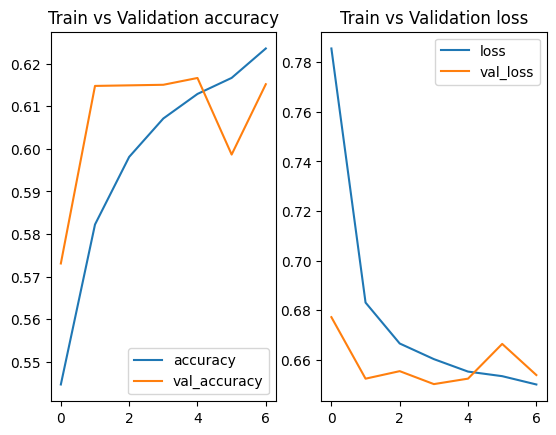

In [ ]:
# @title History dense plots

plot_history(history_dense)

In [ ]:
# @title **Simple dense neural network, image size 100x100x1**

# prepare X_train for dense model
# img_size=50

npix = img_size * img_size
dim = len(X)

X_flat = X.reshape(dim,npix)
# print(X_train_flat.shape)

num_epochs = 50
num_batch = 25

# Define the model
model_dense_100 = Sequential([
    Input(shape=(npix,)),
    Dense(2048, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Early stopping callback
es_100 = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

# Model checkpoint callback
ckpt_100 = ModelCheckpoint(filepath=path+'model_dense_100.cpt',
                           monitor='val_loss',
                           save_best_only=True)

# Compile the model
model_dense_100.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history_dense_100 = model_dense_100.fit(X_flat, y_enc,
                                        epochs=num_epochs,
                                        batch_size=num_batch,
                                        validation_split=0.3,
                                        callbacks=[es_100, ckpt_100])

# Save the model
model_dense_100.save(path+'model_dense.keras')



Epoch 1/50
700/700 [==============================] - 21s 19ms/step - loss: 0.7813 - accuracy: 0.5387 - val_loss: 0.6656 - val_accuracy: 0.5911
Epoch 2/50
700/700 [==============================] - 13s 18ms/step - loss: 0.6811 - accuracy: 0.5773 - val_loss: 0.6628 - val_accuracy: 0.5991
Epoch 3/50
700/700 [==============================] - 12s 17ms/step - loss: 0.6668 - accuracy: 0.5931 - val_loss: 0.6479 - val_accuracy: 0.6211
Epoch 4/50
700/700 [==============================] - 9s 13ms/step - loss: 0.6605 - accuracy: 0.6055 - val_loss: 0.6776 - val_accuracy: 0.5875
Epoch 5/50
700/700 [==============================] - 10s 15ms/step - loss: 0.6582 - accuracy: 0.6112 - val_loss: 0.6783 - val_accuracy: 0.5892
Epoch 6/50
700/700 [==============================] - 9s 13ms/step - loss: 0.6545 - accuracy: 0.6153 - val_loss: 0.6609 - val_accuracy: 0.5995


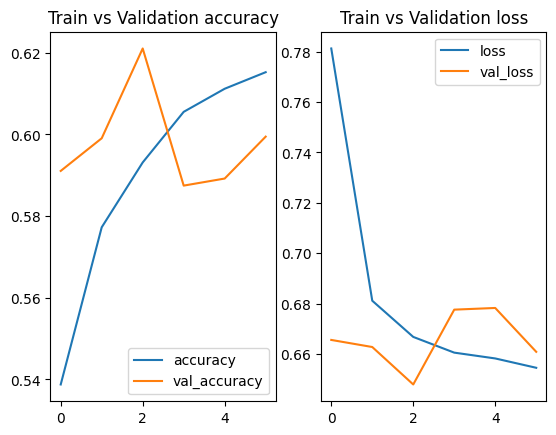

In [ ]:
plot_history(history_dense_100)

### ***Building CNN models***

In [ ]:
# @title **CNN, image size 100x100x1**

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu',
                  kernel_initializer='he_uniform',
                  padding='same',
                  input_shape=(100, 100, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt,
               loss='binary_crossentropy',
               metrics=['accuracy'])
	return model

	# define model
model_ccn1_100 = define_model()


# Early stopping callback
es_cnn1_100 = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

# Model checkpoint callback
ckpt_cnn1_100 = ModelCheckpoint(filepath=path+'model_cnn1_100.cpt',
                           monitor='val_loss',
                           save_best_only=True)


# # Compile the model
# model_cnn.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# Train the model
history_cnn = model_ccn1_100.fit(X, y_enc,
                            epochs=num_epochs,
                            batch_size=num_batch,
                            validation_split=0.3,
                            callbacks=[es_cnn1_100, ckpt_cnn1_100])

# Save the model
model_ccn1_100.save(path+'model_ccn1_100.keras')



Epoch 1/50
700/700 [==============================] - 9s 10ms/step - loss: 0.6924 - accuracy: 0.5476 - val_loss: 0.6563 - val_accuracy: 0.6109
Epoch 2/50
700/700 [==============================] - 6s 9ms/step - loss: 0.6567 - accuracy: 0.6094 - val_loss: 0.6430 - val_accuracy: 0.6400
Epoch 3/50
700/700 [==============================] - 6s 8ms/step - loss: 0.6414 - accuracy: 0.6266 - val_loss: 0.6286 - val_accuracy: 0.6407
Epoch 4/50
700/700 [==============================] - 5s 8ms/step - loss: 0.6323 - accuracy: 0.6374 - val_loss: 0.6303 - val_accuracy: 0.6337
Epoch 5/50
700/700 [==============================] - 6s 9ms/step - loss: 0.6213 - accuracy: 0.6473 - val_loss: 0.6228 - val_accuracy: 0.6457
Epoch 6/50
700/700 [==============================] - 5s 8ms/step - loss: 0.6118 - accuracy: 0.6586 - val_loss: 0.6241 - val_accuracy: 0.6480
Epoch 7/50
700/700 [==============================] - 6s 9ms/step - loss: 0.5969 - accuracy: 0.6723 - val_loss: 0.5973 - val_accuracy: 0.6727
Epoch

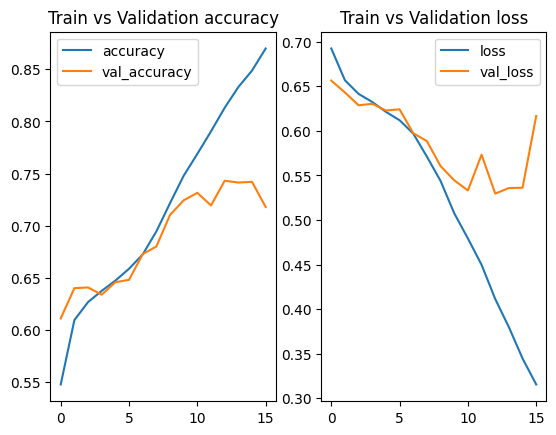

In [ ]:
plot_history(history_cnn)

In [ ]:
# @title **CNN, image size 50x50x1**
# model 1

num_epochs = 50
num_batch = 25

# Define the CNN architecture
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Early stopping callback
es_cnn = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

# Model checkpoint callback
ckpt_cnn = ModelCheckpoint(filepath=path+'model_cnn.cpt',
                           monitor='val_loss',
                           save_best_only=True)


# Compile the model
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history_cnn = model_cnn.fit(X_train, y_train_enc,
                            epochs=num_epochs,
                            batch_size=num_batch,
                            validation_split=0.3,
                            callbacks=[es_cnn, ckpt_cnn])

# Save the model
model_cnn.save(path+'model_cnn.keras')



Epoch 1/50
700/700 [==============================] - 139s 196ms/step - loss: 0.6298 - accuracy: 0.6387 - val_loss: 0.5642 - val_accuracy: 0.7072
Epoch 2/50
700/700 [==============================] - 75s 107ms/step - loss: 0.5285 - accuracy: 0.7350 - val_loss: 0.5010 - val_accuracy: 0.7713
Epoch 3/50
700/700 [==============================] - 80s 114ms/step - loss: 0.4631 - accuracy: 0.7813 - val_loss: 0.4541 - val_accuracy: 0.7877
Epoch 4/50
700/700 [==============================] - 77s 110ms/step - loss: 0.4214 - accuracy: 0.8027 - val_loss: 0.4362 - val_accuracy: 0.8023
Epoch 5/50
700/700 [==============================] - 84s 120ms/step - loss: 0.3767 - accuracy: 0.8299 - val_loss: 0.4117 - val_accuracy: 0.8112
Epoch 6/50
700/700 [==============================] - 78s 112ms/step - loss: 0.3357 - accuracy: 0.8511 - val_loss: 0.4164 - val_accuracy: 0.8152
Epoch 7/50
700/700 [==============================] - 77s 109ms/step - loss: 0.2902 - accuracy: 0.8732 - val_loss: 0.4167 - val_a

In [ ]:
history_cnn_update = continue_training_model(path+'Copy of model_cnn.keras',
                                             X_train,
                                             y_train_enc,
                                             num_epochs,
                                             num_batch,
                                             validation_size=0.3,
                                             callbacks=[es_cnn, ckpt_cnn])

Epoch 1/50
700/700 [==============================] - 77s 108ms/step - loss: 0.1720 - accuracy: 0.9314 - val_loss: 0.5280 - val_accuracy: 0.8083
Epoch 2/50
700/700 [==============================] - 78s 112ms/step - loss: 0.1346 - accuracy: 0.9494 - val_loss: 0.5696 - val_accuracy: 0.8196
Epoch 3/50
700/700 [==============================] - 75s 107ms/step - loss: 0.1004 - accuracy: 0.9628 - val_loss: 0.6700 - val_accuracy: 0.8073
Epoch 4/50
700/700 [==============================] - 76s 108ms/step - loss: 0.0795 - accuracy: 0.9728 - val_loss: 0.6682 - val_accuracy: 0.8072


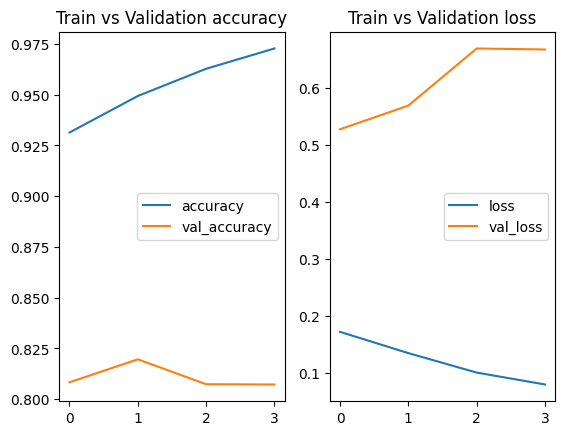

In [ ]:
plot_history(history_cnn)

In [ ]:
# model_cnn was unable to learn the training dataset

In [ ]:
# @title Re running model "model_cnn"
 num_epochs = 50
num_batch = 25
es_cnn = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)
 history_ckp_cnn = continue_training_model(path+'model_cnn.cpt',
                                           X_train,
                                           y_train_enc,
                                           num_epochs,
                                           num_batch,
                                           validation_size=0.3,
                                           callbacks=[es_cnn])


Epoch 1/50
700/700 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.8530
Epoch 1: val_loss improved from inf to 0.41600, saving model to /content/drive/MyDrive/Data Science Academy/Homeworks/Machine Learning/ML W8/model_cnn.cpt
700/700 [==============================] - 73s 103ms/step - loss: 0.3341 - accuracy: 0.8530 - val_loss: 0.4160 - val_accuracy: 0.8208
Epoch 2/50
700/700 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8783
Epoch 2: val_loss improved from 0.41600 to 0.41297, saving model to /content/drive/MyDrive/Data Science Academy/Homeworks/Machine Learning/ML W8/model_cnn.cpt
700/700 [==============================] - 70s 100ms/step - loss: 0.2841 - accuracy: 0.8783 - val_loss: 0.4130 - val_accuracy: 0.8169
Epoch 3/50
700/700 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.8970
Epoch 3: val_loss did not improve from 0.41297
700/700 [==============================] - 71s 101ms/step - loss: 0.2452 - accuracy

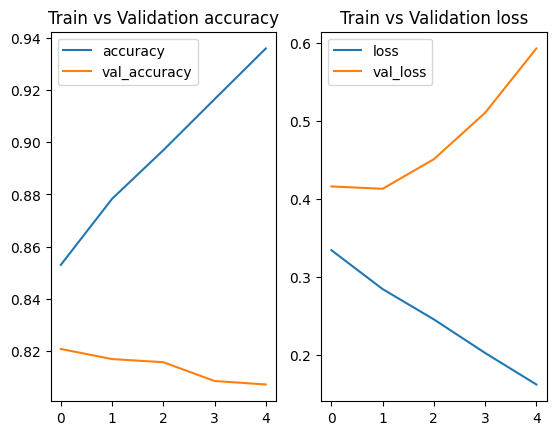

In [ ]:
plot_history(history_ckp_cnn)

In [ ]:
# model_cnn was unable to learn the training dataset

In [ ]:
# @title CNN 2,  image size 50x50x1
num_epochs = 50
num_batch = 25

model_cnn2 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu',
           input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Model checkpoint callback
ckpt_cnn2 = ModelCheckpoint(filepath=path+'model_cnn2.cpt',
                            monitor='val_loss',
                            verbose=0,
                            save_best_only=False,
                            save_weights_only=False,
                            mode="auto")

# Compile the model
model_cnn2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history_cnn2 = model_cnn2.fit(X_train, y_train_enc,
                              epochs=num_epochs,
                              batch_size=num_batch,
                              validation_split=0.3,
                              callbacks=[es_cnn, ckpt_cnn2])

# Save the model
model_cnn2.save(path+'model_cnn2.keras')


Epoch 1/50
700/700 [==============================] - 115s 163ms/step - loss: 0.6563 - accuracy: 0.6560 - val_loss: 0.5329 - val_accuracy: 0.7409
Epoch 2/50
700/700 [==============================] - 95s 135ms/step - loss: 0.5354 - accuracy: 0.7398 - val_loss: 0.5479 - val_accuracy: 0.7248
Epoch 3/50
700/700 [==============================] - 86s 123ms/step - loss: 0.4869 - accuracy: 0.7671 - val_loss: 0.5195 - val_accuracy: 0.7472
Epoch 4/50
700/700 [==============================] - 85s 121ms/step - loss: 0.4415 - accuracy: 0.7962 - val_loss: 0.5764 - val_accuracy: 0.7136
Epoch 5/50
700/700 [==============================] - 87s 125ms/step - loss: 0.3976 - accuracy: 0.8180 - val_loss: 0.4728 - val_accuracy: 0.7831
Epoch 6/50
700/700 [==============================] - 86s 122ms/step - loss: 0.3544 - accuracy: 0.8391 - val_loss: 0.4703 - val_accuracy: 0.7939
Epoch 7/50
700/700 [==============================] - 87s 125ms/step - loss: 0.3151 - accuracy: 0.8617 - val_loss: 0.5080 - val_a

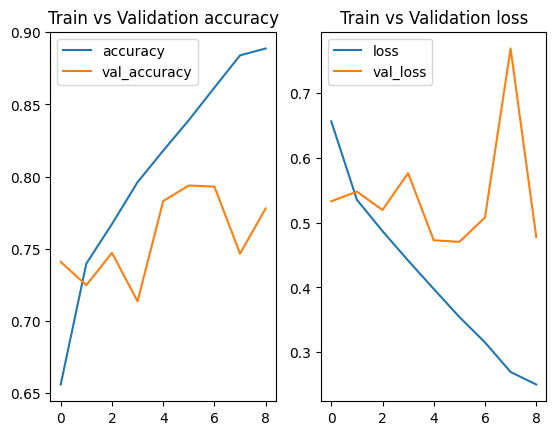

In [ ]:
plot_history(history_cnn2)

In [ ]:
# model_cnn2 was also unable to learn the training dataset;

In [ ]:
# @title CNN 3, image size 100x100x1

num_epochs = 50
num_batch = 25

model_cnn3_100 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu',
           padding='same',
           input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu',
           padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu',
           padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

es_cnn3_100 = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)


# Model checkpoint callback
ckpt_cnn3_100 = ModelCheckpoint(filepath=path+'model_cnn3_100.cpt',
                            monitor='val_loss',
                            verbose=0,
                            save_best_only=False,
                            save_weights_only=False,
                            mode="auto")

# Compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model_cnn3_100.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history_cnn3_100 = model_cnn3_100.fit(X, y_enc,
                              epochs=num_epochs,
                              batch_size=num_batch,
                              validation_split=0.3,
                              callbacks=[es_cnn3_100, ckpt_cnn3_100])

# Save the model
model_cnn3_100.save(path+'model_cnn3_100.keras')


Epoch 1/50
700/700 [==============================] - 13s 17ms/step - loss: 0.6283 - accuracy: 0.6599 - val_loss: 0.6179 - val_accuracy: 0.6692
Epoch 2/50
700/700 [==============================] - 11s 16ms/step - loss: 0.5025 - accuracy: 0.7547 - val_loss: 0.6138 - val_accuracy: 0.6860
Epoch 3/50
700/700 [==============================] - 11s 16ms/step - loss: 0.4120 - accuracy: 0.8151 - val_loss: 0.7471 - val_accuracy: 0.6531
Epoch 4/50
700/700 [==============================] - 11s 15ms/step - loss: 0.3336 - accuracy: 0.8529 - val_loss: 0.5783 - val_accuracy: 0.7251
Epoch 5/50
700/700 [==============================] - 11s 15ms/step - loss: 0.2477 - accuracy: 0.8973 - val_loss: 0.5394 - val_accuracy: 0.7787
Epoch 6/50
700/700 [==============================] - 12s 16ms/step - loss: 0.1751 - accuracy: 0.9312 - val_loss: 0.6222 - val_accuracy: 0.7793
Epoch 7/50
700/700 [==============================] - 11s 16ms/step - loss: 0.1246 - accuracy: 0.9545 - val_loss: 0.6909 - val_accuracy:

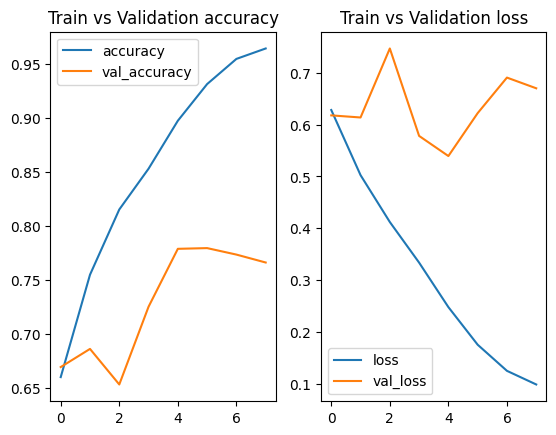

In [ ]:
plot_history(history_cnn3_100)

In [ ]:
# model_cnn3 was also unable to learn the training dataset;

In [ ]:
# @title  CNN 4, image size 100x100x1
# image size 100x100 gray

num_epochs = 50
num_batch = 25

# Define the CNN architecture
model_cnn4_100 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Early stopping callback
es_cnn4_100 = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

# Model checkpoint callback
ckpt_cnn4_100 = ModelCheckpoint(filepath=path+'model_cnn4_100.cpt',
                           monitor='val_loss',
                           save_best_only=True)


# Compile the model
model_cnn4_100.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history_cnn4_100 = model_cnn4_100.fit(X, y_enc,
                            epochs=num_epochs,
                            batch_size=num_batch,
                            validation_split=0.3,
                            callbacks=[es_cnn4_100, ckpt_cnn4_100])

# Save the model
model_cnn4_100.save(path+'model_cnn3.keras') # made mistake saving it




Epoch 1/50
700/700 [==============================] - 12s 12ms/step - loss: 0.6901 - accuracy: 0.5228 - val_loss: 0.6791 - val_accuracy: 0.5649
Epoch 2/50
700/700 [==============================] - 9s 13ms/step - loss: 0.6780 - accuracy: 0.5697 - val_loss: 0.6349 - val_accuracy: 0.6561
Epoch 3/50
700/700 [==============================] - 9s 12ms/step - loss: 0.5884 - accuracy: 0.6887 - val_loss: 0.5263 - val_accuracy: 0.7348
Epoch 4/50
700/700 [==============================] - 8s 12ms/step - loss: 0.4854 - accuracy: 0.7661 - val_loss: 0.4554 - val_accuracy: 0.7825
Epoch 5/50
700/700 [==============================] - 9s 12ms/step - loss: 0.4162 - accuracy: 0.8080 - val_loss: 0.4270 - val_accuracy: 0.8064
Epoch 6/50
700/700 [==============================] - 8s 12ms/step - loss: 0.3705 - accuracy: 0.8305 - val_loss: 0.3992 - val_accuracy: 0.8153
Epoch 7/50
700/700 [==============================] - 8s 12ms/step - loss: 0.3313 - accuracy: 0.8549 - val_loss: 0.3697 - val_accuracy: 0.837

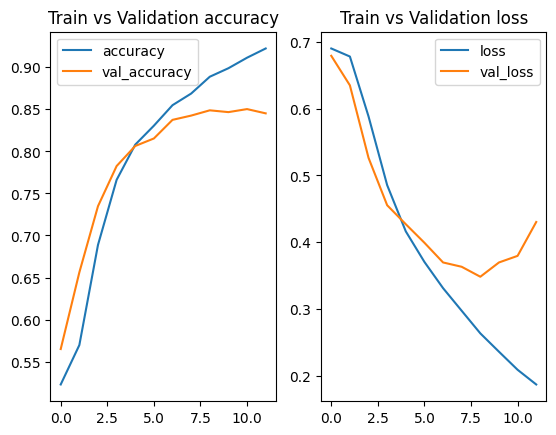

In [ ]:
plot_history(history_cnn4_100)

 Model "**model_cnn4_100**" (image size 100x100 grayscale) best model so far.

 But stil the training loss did not decreases to a point of stability,
 but continues to decrease at the end of the plot. Maybe this model also was also unable to learn the training dataset;

In [ ]:
# @title  CNN 5, image size 100x100x1
# image size 100x100 gray

# NOTE: CNN 5 is same as CNN 4 (but with patience=5),
# could not load CNN 4 to make predinction

num_epochs = 50
num_batch = 32

# Define the CNN architecture
model_cnn5_100 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),


    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Early stopping callback
es_cnn5_100 = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

# Model checkpoint callback
ckpt_cnn5_100 = ModelCheckpoint(filepath=path+'model_cnn5_100.cpt',
                           monitor='val_loss',
                           save_best_only=True)


# Compile the model
model_cnn5_100.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history_cnn5_100 = model_cnn5_100.fit(X_train_100, y_enc,
                            epochs=num_epochs,
                            batch_size=num_batch,
                            validation_split=0.2,
                            callbacks=[es_cnn5_100, ckpt_cnn5_100])

# Save the model
model_cnn5_100.save(path+'model_cnn5.keras')



Epoch 1/50
625/625 [==============================] - 417s 665ms/step - loss: 0.6212 - accuracy: 0.6416 - val_loss: 0.5467 - val_accuracy: 0.7282
Epoch 2/50
625/625 [==============================] - 428s 684ms/step - loss: 0.4994 - accuracy: 0.7595 - val_loss: 0.4578 - val_accuracy: 0.7836
Epoch 3/50
625/625 [==============================] - 421s 674ms/step - loss: 0.4185 - accuracy: 0.8113 - val_loss: 0.3857 - val_accuracy: 0.8264
Epoch 4/50
625/625 [==============================] - 420s 671ms/step - loss: 0.3473 - accuracy: 0.8460 - val_loss: 0.3601 - val_accuracy: 0.8430
Epoch 5/50
625/625 [==============================] - 392s 627ms/step - loss: 0.3077 - accuracy: 0.8666 - val_loss: 0.3468 - val_accuracy: 0.8454
Epoch 6/50
625/625 [==============================] - 393s 628ms/step - loss: 0.2625 - accuracy: 0.8880 - val_loss: 0.3268 - val_accuracy: 0.8594
Epoch 7/50
625/625 [==============================] - 397s 634ms/step - loss: 0.2296 - accuracy: 0.9046 - val_loss: 0.3201 -

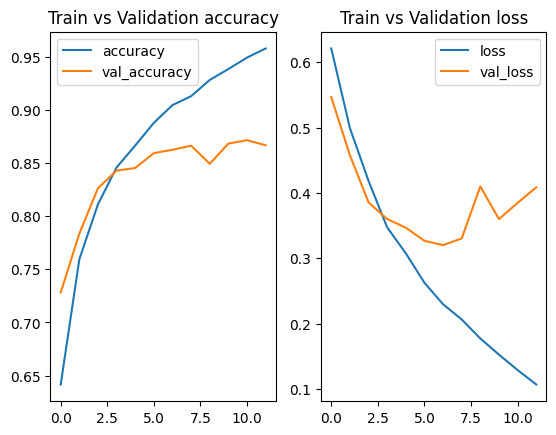

In [ ]:
plot_history(history_cnn5_100)

### ***Evaluate the model and Make predinctions***

In [ ]:
import keras.backend as K


In [ ]:
test_loss, test_acc = model_cnn5_100.evaluate(X_test_100)
print(f"Test accuracy: {test_acc:.3f}")

391/391 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test accuracy: 0.000


In [ ]:
predictions = model_cnn5_100.predict(X_test_100)
score = float(K.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

391/391 [==============================] - 62s 159ms/step
This image is 26.90% cat and 73.10% dog.


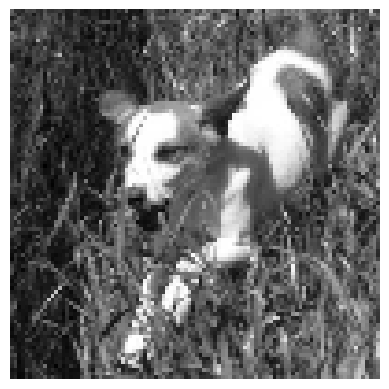

In [ ]:
# Plot the first image in X_test_100
plt.imshow(X_test_100[0], cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

1/1 [==============================] - 0s 248ms/step


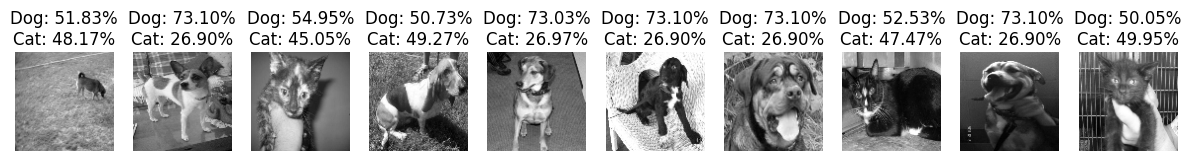

In [ ]:
# @title Make prediction to random  images from the test set

n = 10  # Number of random images from the set
random_indices = np.random.choice(len(X_test_100), n, replace=False)

predictions_n = model_cnn5_100.predict(X_test_100[random_indices])
scores = [float(K.sigmoid(prediction[0])) for prediction in predictions_n]

plt.figure(figsize=(15, 5))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(X_test_100[random_indices[i]], cmap='gray')
    plt.title(f"Dog: {100 * scores[i]:.2f}%\nCat: {100 * (1 - scores[i]):.2f}%")
    plt.axis('off')

plt.show()


### ***Build autoencoders***

In [ ]:
from keras.layers import UpSampling2D, Conv2DTranspose, Reshape
from keras.models import Model

In [ ]:
# @title **Convolutional auto encoder**

#input
input_cnn = Input((100,100,1))

#enc
x = Conv2D(16, (3,3), activation = 'relu', padding='same')(input_cnn)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation = 'relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation = 'relu', padding='same')(x)
enc_x = MaxPooling2D((2,2), padding='same')(x)

# code
code = Flatten()(enc_x)
code = Dense(2, activation='linear')(code)

# decode
x = Dense(8*25*25, activation='relu')(code)
x = Reshape((25, 25, 8))(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
out_cnn = Conv2D(1, (3,3), activation='linear', padding='same')(x)


In [ ]:
ae_cnn = Model(inputs = input_cnn, outputs = out_cnn )

In [ ]:
ae_cnn.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:

X_train_100.shape

(25000, 100, 100, 1)

In [ ]:
ae_cnn.fit(X_train_100,X_train_100, batch_size = 256, epochs = 10)

Epoch 1/10
98/98 [==============================] - 499s 5s/step - loss: 0.0784 - mse: 0.0784
Epoch 2/10
98/98 [==============================] - 501s 5s/step - loss: 0.0481 - mse: 0.0481
Epoch 3/10
98/98 [==============================] - 478s 5s/step - loss: 0.0438 - mse: 0.0438
Epoch 4/10
98/98 [==============================] - 475s 5s/step - loss: 0.0436 - mse: 0.0436
Epoch 5/10
98/98 [==============================] - 496s 5s/step - loss: 0.0435 - mse: 0.0435
Epoch 6/10
98/98 [==============================] - 498s 5s/step - loss: 0.0435 - mse: 0.0435
Epoch 7/10
98/98 [==============================] - 478s 5s/step - loss: 0.0434 - mse: 0.0434
Epoch 8/10
98/98 [==============================] - 468s 5s/step - loss: 0.0434 - mse: 0.0434
Epoch 9/10
98/98 [==============================] - 475s 5s/step - loss: 0.0434 - mse: 0.0434
Epoch 10/10
98/98 [==============================] - 468s 5s/step - loss: 0.0434 - mse: 0.0434


In [ ]:
ae_cnn_outputs = ae_cnn.predict(X_train_100)

782/782 [==============================] - 114s 145ms/step


In [ ]:
ae_cnn_outputs.shape

(25000, 100, 100, 1)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
# Reshape ae_cnn_outputs to a 2D array
num_samples = ae_cnn_outputs.shape[0]
ae_cnn_outputs_2d = ae_cnn_outputs.reshape(num_samples, -1)

# Apply K-means clustering to the flattened representations
num_clusters = 2  # binary classification
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(ae_cnn_outputs_2d)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


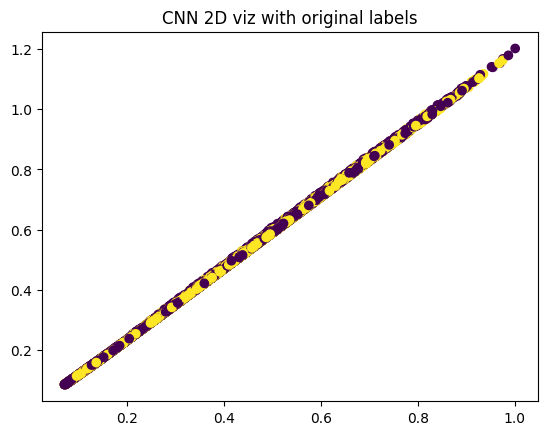

In [ ]:
plt.scatter(ae_cnn_outputs_2d[:,0],ae_cnn_outputs_2d[:,1], c = y_enc)
plt.title('CNN 2D viz with original labels')
plt.show()